# Analyzing Austin PD's Crime Reports Dataset

The dataset is available from the Austin Police Department on https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu.


## Table of Contents 

    I. Introduction
    II. Data Scrubbing
    III. Exploratory Analysis 
    
    Questions:
><ul>
><li><a href="#q1"> 1. What areas of Austin have the highest crime rates?</a></li>
><li><a href="#q2"> 2. How is crime distributed in 78701?</a></li> 
><li><a href="#q3"> 3. How is crime distributed in 78753?</a></li>     
><li><a href="#q4"> 4. How is crime distributed in 78741?</a></li>
><li><a href="#q5"> 5. How is crime distributed in 78745?</a></li>
><li><a href="#q6"> 6. How is crime distributed in 78705?</a></li>
><li><a href="#q7"> 7. How are violent crimes, in particular murder, capital murder, armed robbery, aggrivated assault, and rape distributed?
><li><a href="#q8"> 8. How is crime distributed across different districts and sectors around Austin? Location types?
><li><a href="#q9"> 9. How does violent crime appear on the map?
><li><a href="#q10"> 10. Are there any addresses where violent crime and murder occurs frequently?
</a></li>

## I. Introduction

I began reviewing the Crime Reports dataset, provided by the Austin PD, around the same time I began reviewing its Hate Crimes datasets for analysis, at the beginning of 2020. This is a rather large dataset, containing over 2 million records, spanning from 2003 to the present, and is updated weekly. 

This is a self-paced project, conceived outside of both work and the educational arenas. It is my hope that this project will reveal some actionable insights that will benefit the Austin law enforcement community, news outlets, and anyone else interested in gaining knowledge on how best to combat the problem of crime in the Austin area.

I first attempted importing the data into this notebook using Sodapy's Socrata API method but found it lacking. It didn't import the entire dataset, and added several redundant columns. I, therefore, prefer to manually download the entire dataset and re-download each week after it's updated.

In [1]:
# importing necessary libraries and configurations
import folium
from folium import plugins
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

plt.style.use("classic")
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# loading the data
df = pd.read_csv(
    r"C:\Users\Robert\Crime Reports Analysis\Updated Notebooks\crime_reports.csv"
)

In [3]:
# examining the dataframe
display(df.info())
display(df.isnull().sum())
display(df.head())
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2298584 entries, 0 to 2298583
Data columns (total 27 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Incident Number              int64  
 1   Highest Offense Description  object 
 2   Highest Offense Code         int64  
 3   Family Violence              object 
 4   Occurred Date Time           object 
 5   Occurred Date                object 
 6   Occurred Time                float64
 7   Report Date Time             object 
 8   Report Date                  object 
 9   Report Time                  float64
 10  Location Type                object 
 11  Address                      object 
 12  Zip Code                     float64
 13  Council District             float64
 14  APD Sector                   object 
 15  APD District                 object 
 16  PRA                          object 
 17  Census Tract                 float64
 18  Clearance Status             object 
 19  

None

Incident Number                      0
Highest Offense Description          0
Highest Offense Code                 0
Family Violence                      0
Occurred Date Time                 165
Occurred Date                        0
Occurred Time                       84
Report Date Time                     1
Report Date                          0
Report Time                          1
Location Type                    20913
Address                             12
Zip Code                         14133
Council District                 47105
APD Sector                        8969
APD District                      9444
PRA                              10705
Census Tract                   1559526
Clearance Status                605887
Clearance Date                  336681
UCR Category                   1514791
Category Description           1514791
X-coordinate                     10128
Y-coordinate                     10128
Latitude                         38822
Longitude                

,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,Location Type,Address,Zip Code,Council District,APD Sector,APD District,PRA,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
0,20191571574,FRAUD - OTHER,1199,N,06/03/2019 04:00:00 PM,06/03/2019,1600.0,06/06/2019 05:34:00 PM,06/06/2019,1734.0,DEPARTMENT / DISCOUNT STORE,10817 BALLARD PATH,78717.0,6.0,AD,5,573,203.11,NaN,NaN,NaN,NaN,3097785.0,3097785.0,30.483646,-97.789495,"(30.48364631, -97.7894953)"
1,20191550153,DEADLY CONDUCT,408,N,06/04/2019 03:12:00 AM,06/04/2019,312.0,06/04/2019 03:16:00 AM,06/04/2019,316.0,RESIDENCE / HOME,8312 N IH 35 SVRD SB,78753.0,4.0,ED,1,250,18.06,N,06/06/2019,13A,Aggravated Assault,3128227.0,3128227.0,30.346646,-97.696573,"(30.34664576, -97.69657342)"
2,20195022816,THEFT OF LICENSE PLATE,614,N,06/03/2019 03:00:00 PM,06/03/2019,1500.0,06/04/2019 03:22:00 PM,06/04/2019,1522.0,RESIDENCE / HOME,6312 LIBYAN DR,78745.0,2.0,FR,4,509,24.09,N,06/04/2019,23G,Theft,3098393.0,3098393.0,30.205267,-97.794900,"(30.20526729, -97.79490043)"
3,20205007833,RUNAWAY CHILD,4100,N,02/22/2020 06:00:00 PM,02/22/2020,1800.0,02/24/2020 06:03:00 PM,02/24/2020,1803.0,RESIDENCE / HOME,13012 DEARBONNE DR,78617.0,2.0,HE,7,612,NaN,N,03/03/2020,NaN,NaN,3155456.0,3155456.0,30.176140,-97.615031,"(30.17613952, -97.6150307)"
4,20191671388,BURGLARY OF RESIDENCE,500,N,06/14/2019 12:00:00 PM,06/14/2019,1200.0,06/16/2019 10:00:00 PM,06/16/2019,2200.0,RESIDENCE / HOME,3809 SPICEWOOD SPRINGS RD EB,78731.0,10.0,BA,8,256,17.51,N,09/18/2019,220,Burglary,3111039.0,3111039.0,30.364987,-97.750587,"(30.36498691, -97.75058749)"


,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,Location Type,Address,Zip Code,Council District,APD Sector,APD District,PRA,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
2298579,20171941448,FAMILY DISTURBANCE,3400,N,07/13/2017 07:43:00 PM,07/13/2017,1943.0,07/13/2017 08:11:00 PM,07/13/2017,2011.0,RESIDENCE / HOME,6932 THISTLE HILL WAY,78754.0,1.0,CH,8,226,NaN,NaN,NaN,NaN,NaN,3154587.0,3154587.0,30.347707,-97.612952,"(30.34770722, -97.61295164)"
2298580,20203561236,THEFT,600,N,12/21/2020 08:00:00 PM,12/21/2020,2000.0,12/21/2020 08:40:00 PM,12/21/2020,2040.0,CONVENIENCE STORE,8010 BRODIE LN,78749.0,8.0,DA,7,86,NaN,N,12/28/2020,23H,Theft,3084883.0,3084883.0,30.202974,-97.837738,"(30.20297401, -97.83773794)"
2298581,20143361827,POSS CONTROLLED SUB/NARCOTIC,1800,N,12/02/2014 10:31:00 PM,12/02/2014,2231.0,12/02/2014 10:31:00 PM,12/02/2014,2231.0,STREETS / HWY / ROAD / ALLEY,S SH 130 SVRD NB / FALLWELL LN,78617.0,2.0,HE,8,501,NaN,C,12/07/2014,NaN,NaN,3153085.0,3153085.0,30.209501,-97.621600,"(30.20950083, -97.62160012)"
2298582,20121740243,CRIMINAL MISCHIEF,1400,N,06/22/2012 02:45:00 AM,06/22/2012,245.0,06/22/2012 03:27:00 AM,06/22/2012,327.0,STREETS / HWY / ROAD / ALLEY,4529 AVENUE C,78751.0,9.0,BA,5,319,3.05,N,06/28/2012,NaN,NaN,3118332.0,3118332.0,30.311192,-97.728909,"(30.31119165, -97.72890891)"
2298583,20121570235,THEFT,600,N,06/05/2012 03:35:00 AM,06/05/2012,335.0,06/05/2012 03:35:00 AM,06/05/2012,335.0,GAS / SERVICE STATIONS,8656 SPICEWOOD SPRINGS RD,78759.0,6.0,AD,6,187,NaN,C,06/09/2012,23H,Theft,3104030.0,3104030.0,30.433453,-97.770999,"(30.43345341, -97.7709989)"


## II. Data Prep

There are several columns we don't need which we'll drop. We'll index the data according to the OCCURRED DATE TIME column. The following code creates a reproducible script for scrubbing and parsing the data.

In [4]:
def clean_data(df):
    drop_col = [
        "Incident Number",
        "Occurred Time",
        "Occurred Date Time",
        "Highest Offense Code",
        "Census Tract",
        "PRA",
        "Report Date",
        "Report Time",
        "UCR Category",
        "Category Description",
        "X-coordinate",
        "Y-coordinate",
        "Location",
    ]
    df.drop(drop_col, axis=1, inplace=True)
    df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
    fillna = [
        "zip_code",
        "location_type",
        "council_district",
        "apd_district",
        "apd_sector",
    ]
    df[fillna].fillna("N/A", inplace=True)
    date_col = ["occurred_date", "report_date_time", "clearance_date"]
    cat_col = [
        "highest_offense_description",
        "zip_code",
        "location_type",
        "council_district",
        "apd_district",
        "apd_sector",
    ]
    df[date_col] = df[date_col].astype("datetime64")
    df[cat_col] = df[cat_col].astype("category")
    df["year"] = pd.to_datetime(df["occurred_date"], format="%m/%d/%Y").dt.year
    df["month"] = pd.to_datetime(df["occurred_date"], format="%m/%d/%Y").dt.month
    df["week"] = pd.to_datetime(df["occurred_date"], format="%m/%d/%Y").dt.week
    df["day"] = pd.to_datetime(df["occurred_date"], format="%m/%d/%Y").dt.day
    df.set_index(["occurred_date"], inplace=True)
    df.sort_index(inplace=True)
    return df


df = clean_data(df)

In [5]:
# reexamining the dataframe
display(df.info())
display(df.index)
display(df.isnull().sum())
display(df.head())
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2298584 entries, 2003-01-01 to 2021-01-02
Data columns (total 17 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   highest_offense_description  category      
 1   family_violence              object        
 2   report_date_time             datetime64[ns]
 3   location_type                category      
 4   address                      object        
 5   zip_code                     category      
 6   council_district             category      
 7   apd_sector                   category      
 8   apd_district                 category      
 9   clearance_status             object        
 10  clearance_date               datetime64[ns]
 11  latitude                     float64       
 12  longitude                    float64       
 13  year                         int64         
 14  month                        int64         
 15  week                         int64

None

DatetimeIndex(['2003-01-01', '2003-01-01', '2003-01-01', '2003-01-01',
               '2003-01-01', '2003-01-01', '2003-01-01', '2003-01-01',
               '2003-01-01', '2003-01-01',
               ...
               '2021-01-02', '2021-01-02', '2021-01-02', '2021-01-02',
               '2021-01-02', '2021-01-02', '2021-01-02', '2021-01-02',
               '2021-01-02', '2021-01-02'],
              dtype='datetime64[ns]', name='occurred_date', length=2298584, freq=None)

highest_offense_description         0
family_violence                     0
report_date_time                    1
location_type                   20913
address                            12
zip_code                        14133
council_district                47105
apd_sector                       8969
apd_district                     9444
clearance_status               605887
clearance_date                 336681
latitude                        38822
longitude                       38822
year                                0
month                               0
week                                0
day                                 0
dtype: int64

,highest_offense_description,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,clearance_status,clearance_date,latitude,longitude,year,month,week,day
occurred_date,,,,,,,,,,,,,,,,,
2003-01-01,DISTURBANCE - OTHER,N,2003-01-01 02:19:00,STREETS / HWY / ROAD / ALLEY,2600 BLOCK GWENDOLYN LN,78748.0,5.0,FR,1,N,2003-01-15,30.174853,-97.836622,2003,1,1,1
2003-01-01,IDENTITY THEFT,N,2007-01-08 11:44:00,RESIDENCE / HOME,11004 BEXLEY LN,78739.0,8.0,DA,8,NaN,2007-01-09,30.184272,-97.886732,2003,1,1,1
2003-01-01,POSS OF DRUG PARAPHERNALIA,N,2003-01-01 22:53:00,FIELD / WOODS,3800 MOUNT BONNELL RD,78731.0,10.0,BA,7,N,2003-01-06,30.321048,-97.773540,2003,1,1,1
2003-01-01,CRIMINAL MISCHIEF,N,2003-01-02 12:05:00,RESIDENCE / HOME,1001 GULLETT ST,78702.0,3.0,CH,2,N,NaT,30.259596,-97.694540,2003,1,1,1
2003-01-01,ASSAULT W/INJURY-FAM/DATE VIOL,Y,2003-01-01 21:42:00,RESIDENCE / HOME,1106 E OLTORF ST,78704.0,9.0,HE,1,C,2003-01-03,30.235412,-97.744959,2003,1,1,1


,highest_offense_description,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,clearance_status,clearance_date,latitude,longitude,year,month,week,day
occurred_date,,,,,,,,,,,,,,,,,
2021-01-02,BURGLARY OF VEHICLE,N,2021-01-03 01:15:00,RESIDENCE / HOME,5811 BERKMAN DR,78723.0,4.0,ID,4,NaN,NaT,30.312368,-97.692964,2021,1,53,2
2021-01-02,PROTECTIVE ORDER,N,2021-01-02 15:55:00,RESTAURANTS,9900 S IH 35 SB,78748.0,5.0,FR,2,NaN,NaT,30.159396,-97.789940,2021,1,53,2
2021-01-02,VIOL OF EMERG PROTECTIVE ORDER,N,2021-01-02 19:56:00,RESIDENCE / HOME,1221 BARTON HILLS DR,78704.0,5.0,DA,1,NaN,NaT,30.261339,-97.774252,2021,1,53,2
2021-01-02,BURGLARY OF VEHICLE,N,2021-01-02 14:35:00,RESIDENCE / HOME,3704 SPEEDWAY,78705.0,9.0,BA,1,NaN,NaT,30.300306,-97.734077,2021,1,53,2
2021-01-02,BURGLARY OF VEHICLE,N,2021-01-02 14:48:00,PARKING LOTS / GARAGE,4404 E OLTORF ST,78741.0,3.0,HE,4,NaN,NaT,30.227065,-97.726246,2021,1,53,2


## III. Exploratory Analysis

<a id='q1'></a>
### A. Question 1. What areas of Austin have the highest crime rates? 

78741.0    206511
78753.0    178662
78701.0    168241
78758.0    159044
78704.0    154439
78745.0    150623
78702.0    136658
78744.0    126139
78723.0    118241
78752.0     84368
78748.0     68018
78759.0     66240
78751.0     64011
78757.0     57823
78705.0     57013
78721.0     47661
78749.0     40381
78724.0     37626
78727.0     35828
78703.0     35152
78731.0     28620
78746.0     28100
78729.0     25241
78750.0     23672
78754.0     22788
Name: zip_code, dtype: int64

78741.0    0.090399
78753.0    0.078208
78701.0    0.073646
78758.0    0.069620
78704.0    0.067604
78745.0    0.065934
78702.0    0.059821
78744.0    0.055216
78723.0    0.051759
78752.0    0.036931
78748.0    0.029774
78759.0    0.028996
78751.0    0.028020
78757.0    0.025312
78705.0    0.024957
78721.0    0.020863
78749.0    0.017676
78724.0    0.016470
78727.0    0.015683
78703.0    0.015388
78731.0    0.012528
78746.0    0.012301
78729.0    0.011049
78750.0    0.010362
78754.0    0.009975
Name: zip_code, dtype: float64

<AxesSubplot:title={'center':'Top 25 zip codes, overall crime (2003-present)'}>

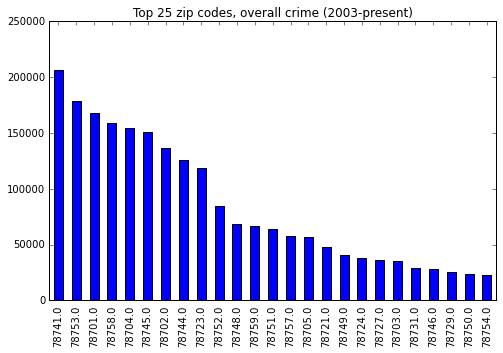

In [6]:
# Create and show dataframe for crime rates by zipcode and as percentages
display(df.zip_code.value_counts().head(25))
display(df.zip_code.value_counts(normalize=True).head(25))

# Visualizing the top 25 areas for crime
df.zip_code.value_counts().head(25).plot.bar(
    title="Top 25 zip codes, overall crime (2003-present)", figsize=(8, 5)
)

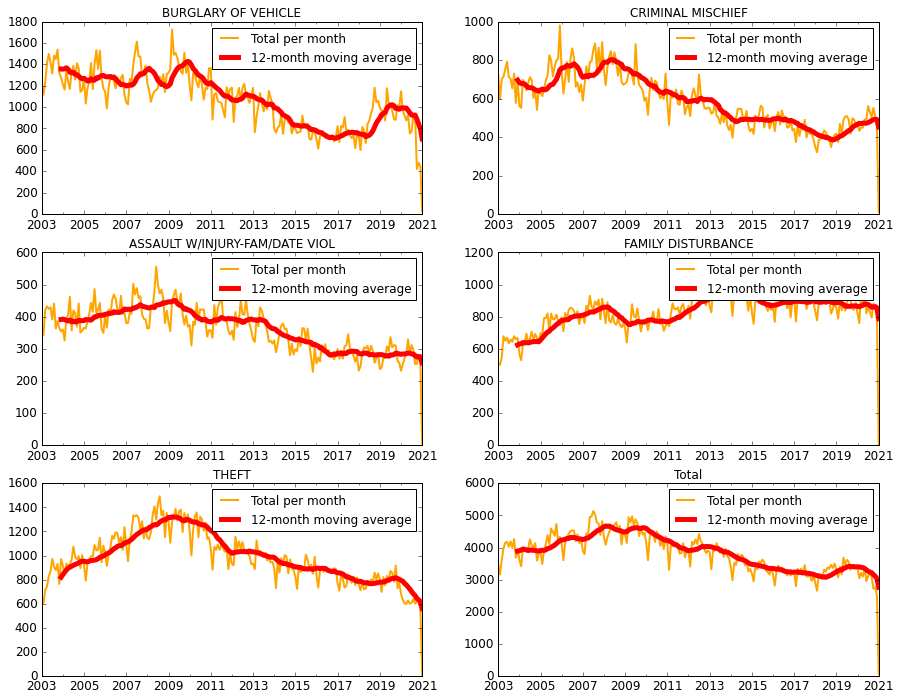

In [23]:
top_5 = df.query(
    'highest_offense_description == ["BURGLARY OF VEHICLE", "THEFT", "FAMILY DISTURBANCE", "CRIMINAL MISCHIEF", "ASSAULT W/INJURY-FAM/DATE VIOL"]'
)

monthly_top_5 = pd.DataFrame(
    top_5[top_5["highest_offense_description"] == "BURGLARY OF VEHICLE"]
    .resample("M")
    .size()
)
monthly_top_5.columns = ["BURGLARY OF VEHICLE"]

for i in top_5["highest_offense_description"].unique():
    monthly_top_5[i] = pd.DataFrame(
        top_5[top_5["highest_offense_description"] == i].resample("M").size()
    )

monthly_top_5["Total"] = monthly_top_5.sum(axis=1)

crimeTypes = monthly_top_5.columns

plt.figure(1, figsize=(15, 20))
i = 521
for eachCrime in crimeTypes:
    plt.subplot(i)
    monthly_top_5[eachCrime].plot(color="orange", linewidth=2, label="Total per month")
    monthly_top_5[eachCrime].rolling(window=12).mean().plot(
        color="red", linewidth=5, label="12-month moving average"
    )
    plt.title(eachCrime, fontsize=12)
    plt.xlabel("")
    plt.legend(prop={"size": 12})
    plt.tick_params(labelsize=12)
    i = i + 1

<a id='q2'></a>
### B. Question 2. How is crime distributed in 78701 (downtown Austin)? 

PUBLIC INTOXICATION               17152
THEFT                             15744
BURGLARY OF VEHICLE                9256
WARRANT ARREST NON TRAFFIC         8966
DWI                                8307
ASSAULT WITH INJURY                7501
VIOL CITY ORDINANCE - OTHER        6188
POSS OF DRUG PARAPHERNALIA         6032
CRIMINAL MISCHIEF                  5799
CRIMINAL TRESPASS                  3903
POSSESSION OF MARIJUANA            3380
DISTURBANCE - OTHER                3347
CUSTODY ARREST TRAFFIC WARR        2998
POSS CONTROLLED SUB/NARCOTIC       2896
CAMPING IN PARK                    2789
VOCO - ALCOHOL  CONSUMPTION        2690
CRIMINAL TRESPASS/TRANSIENT        2578
ASSAULT BY CONTACT                 2573
THEFT OF BICYCLE                   2505
URINATING IN PUBLIC PLACE          2336
FAMILY DISTURBANCE                 2145
DOC FIGHTING                       2109
PROTECTIVE ORDER                   2101
ASSAULT W/INJURY-FAM/DATE VIOL     1725
Name: highest_offense_description, dtype

PUBLIC INTOXICATION               0.101949
THEFT                             0.093580
BURGLARY OF VEHICLE               0.055016
WARRANT ARREST NON TRAFFIC        0.053293
DWI                               0.049376
ASSAULT WITH INJURY               0.044585
VIOL CITY ORDINANCE - OTHER       0.036781
POSS OF DRUG PARAPHERNALIA        0.035853
CRIMINAL MISCHIEF                 0.034468
CRIMINAL TRESPASS                 0.023199
POSSESSION OF MARIJUANA           0.020090
DISTURBANCE - OTHER               0.019894
CUSTODY ARREST TRAFFIC WARR       0.017820
POSS CONTROLLED SUB/NARCOTIC      0.017213
CAMPING IN PARK                   0.016577
VOCO - ALCOHOL  CONSUMPTION       0.015989
CRIMINAL TRESPASS/TRANSIENT       0.015323
ASSAULT BY CONTACT                0.015294
THEFT OF BICYCLE                  0.014889
URINATING IN PUBLIC PLACE         0.013885
FAMILY DISTURBANCE                0.012750
DOC FIGHTING                      0.012536
PROTECTIVE ORDER                  0.012488
ASSAULT W/I

<AxesSubplot:title={'center':'Crime Distribution (78701)'}, ylabel='highest_offense_description'>

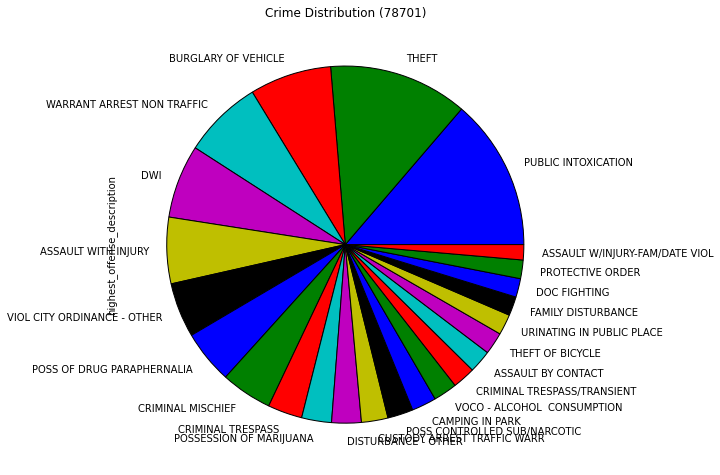

In [7]:
# Examining crime in the 78701 area
df_01 = df[df.zip_code == 78701]

# Create a dataframe for the top crime categories in the zipcode
df_01_off = df_01.highest_offense_description.value_counts().head(24)

# Display the different crime values & then as percentages
display(df_01_off)
display(df_01.highest_offense_description.value_counts(normalize=True).head(24))
df_01_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78701)")

<a id='q3'></a>
### C. Question 2. How is crime distributed in 78753? 

THEFT                             17110
BURGLARY OF VEHICLE               15943
FAMILY DISTURBANCE                14611
CRIMINAL MISCHIEF                  9448
THEFT BY SHOPLIFTING               7627
ASSAULT W/INJURY-FAM/DATE VIOL     7130
BURGLARY OF RESIDENCE              6058
DWI                                4992
DISTURBANCE - OTHER                4745
CUSTODY ARREST TRAFFIC WARR        4348
HARASSMENT                         4238
AUTO THEFT                         4201
POSS OF DRUG PARAPHERNALIA         3723
PUBLIC INTOXICATION                3365
ASSAULT WITH INJURY                3297
CRIMINAL TRESPASS                  3133
POSS CONTROLLED SUB/NARCOTIC       2971
RUNAWAY CHILD                      2925
WARRANT ARREST NON TRAFFIC         2795
POSSESSION OF MARIJUANA            2702
BURGLARY NON RESIDENCE             2494
VIOL CITY ORDINANCE - OTHER        1866
Name: highest_offense_description, dtype: int64

'----------------------------------'

THEFT                             0.095767
BURGLARY OF VEHICLE               0.089236
FAMILY DISTURBANCE                0.081780
CRIMINAL MISCHIEF                 0.052882
THEFT BY SHOPLIFTING              0.042690
ASSAULT W/INJURY-FAM/DATE VIOL    0.039908
BURGLARY OF RESIDENCE             0.033908
DWI                               0.027941
DISTURBANCE - OTHER               0.026559
CUSTODY ARREST TRAFFIC WARR       0.024336
HARASSMENT                        0.023721
AUTO THEFT                        0.023514
POSS OF DRUG PARAPHERNALIA        0.020838
PUBLIC INTOXICATION               0.018834
ASSAULT WITH INJURY               0.018454
CRIMINAL TRESPASS                 0.017536
POSS CONTROLLED SUB/NARCOTIC      0.016629
RUNAWAY CHILD                     0.016372
WARRANT ARREST NON TRAFFIC        0.015644
POSSESSION OF MARIJUANA           0.015124
BURGLARY NON RESIDENCE            0.013959
VIOL CITY ORDINANCE - OTHER       0.010444
Name: highest_offense_description, dtype: float64

<AxesSubplot:title={'center':'Crime Distribution (78753)'}, ylabel='highest_offense_description'>

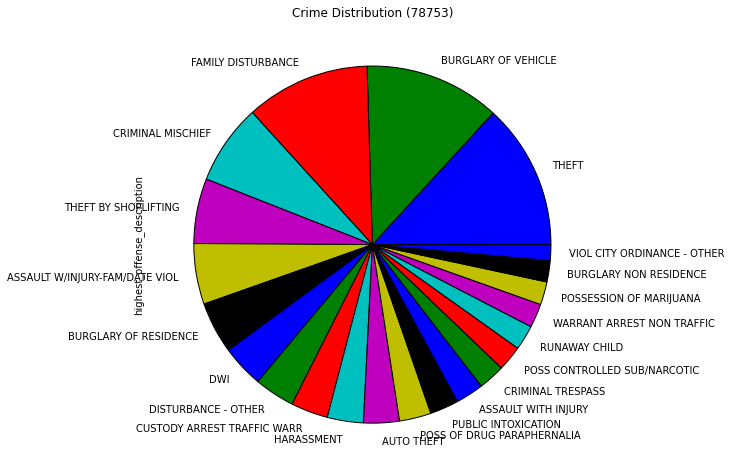

In [8]:
# Examining crime in the 78753 area
df_53 = df[df.zip_code == 78753]

# Create a dataframe for the top 10 crime categories in the zipcode
df_53_off = df_53.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages
display(df_53_off)
display("----------------------------------")
display(df_53.highest_offense_description.value_counts(normalize=True).head(22))
df_53_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78753)")

<a id='q4'></a>
### D. Question 4. How is crime distributed in 78741 (E Riverside/Oltorf)? 

FAMILY DISTURBANCE                20302
BURGLARY OF VEHICLE               19786
THEFT                             15573
CRIMINAL MISCHIEF                 11019
ASSAULT W/INJURY-FAM/DATE VIOL     9609
BURGLARY OF RESIDENCE              8871
PUBLIC INTOXICATION                6379
CUSTODY ARREST TRAFFIC WARR        6011
DWI                                5649
HARASSMENT                         5494
DISTURBANCE - OTHER                5156
AUTO THEFT                         4604
ASSAULT WITH INJURY                4526
CRIMINAL TRESPASS                  3910
POSS CONTROLLED SUB/NARCOTIC       3853
POSSESSION OF MARIJUANA            3793
THEFT BY SHOPLIFTING               3574
POSS OF DRUG PARAPHERNALIA         3534
WARRANT ARREST NON TRAFFIC         3448
RUNAWAY CHILD                      2787
VIOL CITY ORDINANCE - OTHER        2196
Name: highest_offense_description, dtype: int64

'----------------------------------'

FAMILY DISTURBANCE                0.098310
BURGLARY OF VEHICLE               0.095811
THEFT                             0.075410
CRIMINAL MISCHIEF                 0.053358
ASSAULT W/INJURY-FAM/DATE VIOL    0.046530
BURGLARY OF RESIDENCE             0.042957
PUBLIC INTOXICATION               0.030889
CUSTODY ARREST TRAFFIC WARR       0.029107
DWI                               0.027354
HARASSMENT                        0.026604
DISTURBANCE - OTHER               0.024967
AUTO THEFT                        0.022294
ASSAULT WITH INJURY               0.021917
CRIMINAL TRESPASS                 0.018934
POSS CONTROLLED SUB/NARCOTIC      0.018658
POSSESSION OF MARIJUANA           0.018367
THEFT BY SHOPLIFTING              0.017307
POSS OF DRUG PARAPHERNALIA        0.017113
WARRANT ARREST NON TRAFFIC        0.016696
RUNAWAY CHILD                     0.013496
VIOL CITY ORDINANCE - OTHER       0.010634
Name: highest_offense_description, dtype: float64

<AxesSubplot:title={'center':'Crime Distribution (78741)'}, ylabel='highest_offense_description'>

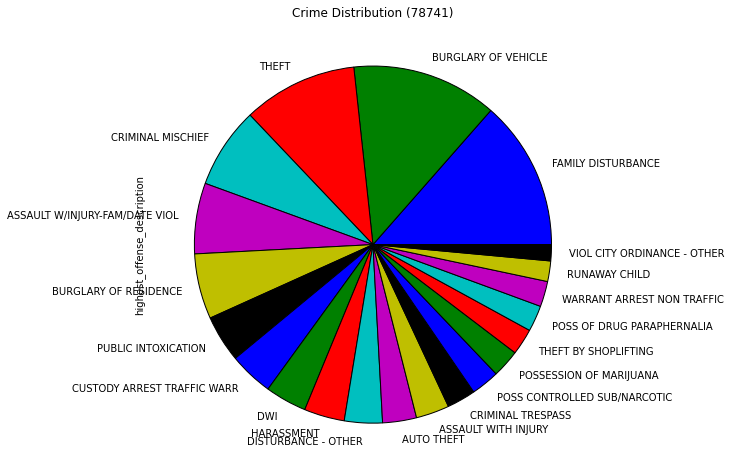

In [9]:
# Examining crime in the 78741 area (the highest amount of crime of any Austin zip code)
df_41 = df[df.zip_code == 78741]

# Create a dataframe for the top crime categories in the zipcode
df_41_off = df_41.highest_offense_description.value_counts().head(21)

# Display the different crime values & then as percentages
display(df_41_off)
display("----------------------------------")
display(df_41.highest_offense_description.value_counts(normalize=True).head(21))
df_41_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78741)")

<a id='q5'></a>
### E. Question 5. How is crime distributed in 78745 (far south Austin)?

FAMILY DISTURBANCE                14892
BURGLARY OF VEHICLE               14751
THEFT                             13538
CRIMINAL MISCHIEF                  8489
BURGLARY OF RESIDENCE              5866
ASSAULT W/INJURY-FAM/DATE VIOL     5744
HARASSMENT                         5125
DISTURBANCE - OTHER                4502
DWI                                4411
PUBLIC INTOXICATION                3995
CUSTODY ARREST TRAFFIC WARR        3248
BURGLARY NON RESIDENCE             2918
AUTO THEFT                         2844
ASSAULT WITH INJURY                2660
RUNAWAY CHILD                      2594
POSSESSION OF MARIJUANA            2586
WARRANT ARREST NON TRAFFIC         2108
POSS CONTROLLED SUB/NARCOTIC       2013
THEFT BY SHOPLIFTING               1974
CRIMINAL TRESPASS                  1950
IDENTITY THEFT                     1572
POSS OF DRUG PARAPHERNALIA         1516
Name: highest_offense_description, dtype: int64

'----------------------------------'

FAMILY DISTURBANCE                0.098869
BURGLARY OF VEHICLE               0.097933
THEFT                             0.089880
CRIMINAL MISCHIEF                 0.056359
BURGLARY OF RESIDENCE             0.038945
ASSAULT W/INJURY-FAM/DATE VIOL    0.038135
HARASSMENT                        0.034025
DISTURBANCE - OTHER               0.029889
DWI                               0.029285
PUBLIC INTOXICATION               0.026523
CUSTODY ARREST TRAFFIC WARR       0.021564
BURGLARY NON RESIDENCE            0.019373
AUTO THEFT                        0.018882
ASSAULT WITH INJURY               0.017660
RUNAWAY CHILD                     0.017222
POSSESSION OF MARIJUANA           0.017169
WARRANT ARREST NON TRAFFIC        0.013995
POSS CONTROLLED SUB/NARCOTIC      0.013364
THEFT BY SHOPLIFTING              0.013106
CRIMINAL TRESPASS                 0.012946
IDENTITY THEFT                    0.010437
POSS OF DRUG PARAPHERNALIA        0.010065
Name: highest_offense_description, dtype: float64

<AxesSubplot:title={'center':'Crime Distribution (78745)'}, ylabel='highest_offense_description'>

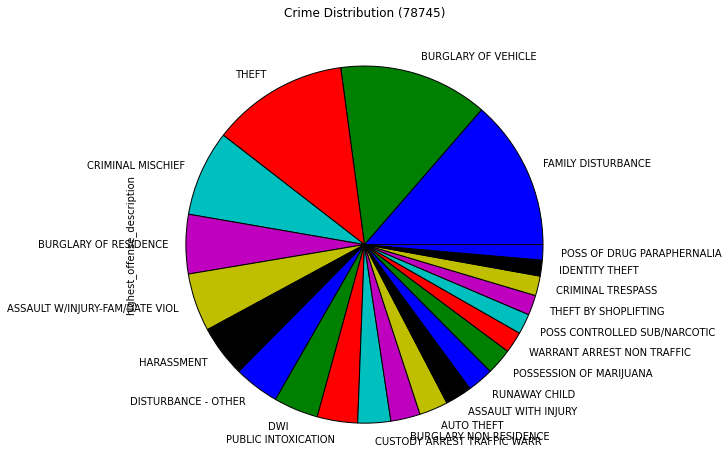

In [10]:
# Examining crime in the 78745 area
df_45 = df[df.zip_code == 78745]

# Create a dataframe for the top 10 crime categories in the zipcode
df_45_off = df_45.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages
display(df_45_off)
display("----------------------------------")
display(df_45.highest_offense_description.value_counts(normalize=True).head(22))
df_45_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78745)")

<a id='q6'></a>
### F. Question 6. How is crime distributed in 78705 (UT campus area)?

BURGLARY OF VEHICLE               8611
THEFT                             5594
CRIMINAL MISCHIEF                 4957
THEFT OF BICYCLE                  3467
PUBLIC INTOXICATION               2627
BURGLARY OF RESIDENCE             2116
WARRANT ARREST NON TRAFFIC        1549
CRIMINAL TRESPASS                 1341
AUTO THEFT                        1303
ASSAULT WITH INJURY               1245
DWI                               1219
HARASSMENT                        1210
FAMILY DISTURBANCE                1183
DISTURBANCE - OTHER               1113
BURGLARY NON RESIDENCE             877
CRIMINAL TRESPASS/TRANSIENT        868
VIOL CITY ORDINANCE - OTHER        791
CUSTODY ARREST TRAFFIC WARR        783
GRAFFITI                           776
ASSAULT W/INJURY-FAM/DATE VIOL     689
POSSESSION OF MARIJUANA            657
ASSAULT BY CONTACT                 615
Name: highest_offense_description, dtype: int64

'----------------------------------'

BURGLARY OF VEHICLE               0.151036
THEFT                             0.098118
CRIMINAL MISCHIEF                 0.086945
THEFT OF BICYCLE                  0.060811
PUBLIC INTOXICATION               0.046077
BURGLARY OF RESIDENCE             0.037114
WARRANT ARREST NON TRAFFIC        0.027169
CRIMINAL TRESPASS                 0.023521
AUTO THEFT                        0.022854
ASSAULT WITH INJURY               0.021837
DWI                               0.021381
HARASSMENT                        0.021223
FAMILY DISTURBANCE                0.020750
DISTURBANCE - OTHER               0.019522
BURGLARY NON RESIDENCE            0.015382
CRIMINAL TRESPASS/TRANSIENT       0.015225
VIOL CITY ORDINANCE - OTHER       0.013874
CUSTODY ARREST TRAFFIC WARR       0.013734
GRAFFITI                          0.013611
ASSAULT W/INJURY-FAM/DATE VIOL    0.012085
POSSESSION OF MARIJUANA           0.011524
ASSAULT BY CONTACT                0.010787
Name: highest_offense_description, dtype: float64

<AxesSubplot:title={'center':'Crime Distribution (78705)'}, ylabel='highest_offense_description'>

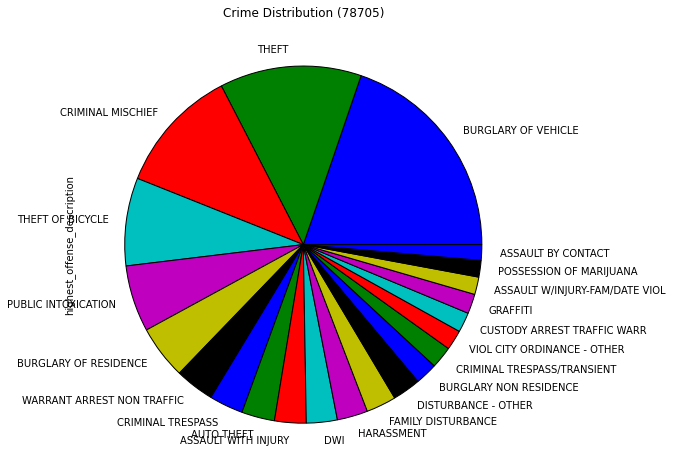

In [11]:
# Examining crime in the 78705 area
df_05 = df[df.zip_code == 78705]

# Create a dataframe for the top 10 crime categories in the zipcode
df_05_off = df_05.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages
display(df_05_off)
display("----------------------------------")
display(df_05.highest_offense_description.value_counts(normalize=True).head(22))
df_05_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78705)")

<a id='q7'></a>
### H. Question 7. How are violent crimes, in particular murder, capital murder, armed robbery, aggrivated assault, and rape distributed? 

In [12]:
# Creating separate dataframes for overall & violent crime
df_viol = df.query(
    'highest_offense_description == ["AGG ASSAULT", "AGG ROBBERY/DEADLY WEAPON", "CAPITAL MURDER", "MURDER", "RAPE"]'
)
df_viol_mur = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER"]')
df_agg_asslt = df[df.highest_offense_description == "AGG ASSAULT"]
df_agg_robbery = df[df.highest_offense_description == "AGG ROBBERY/DEADLY WEAPON"]

# Creating yearly dataframes
# Annual overall crime
df_17 = df[df.year == 2017]
df_18 = df[df.year == 2018]
df_19 = df[df.year == 2019]
df_20 = df[df.year == 2020]

# Annual violent crime
df_viol_17 = df_viol[df_viol.year == 2017]
df_viol_18 = df_viol[df_viol.year == 2018]
df_viol_19 = df_viol[df_viol.year == 2019]
df_viol_20 = df_viol[df_viol.year == 2020]

# Annual murders
df_viol_mur_17 = df_viol_mur[df_viol_mur.year == 2017]
df_viol_mur_18 = df_viol_mur[df_viol_mur.year == 2018]
df_viol_mur_19 = df_viol_mur[df_viol_mur.year == 2019]
df_viol_mur_20 = df_viol_mur[df_viol_mur.year == 2020]

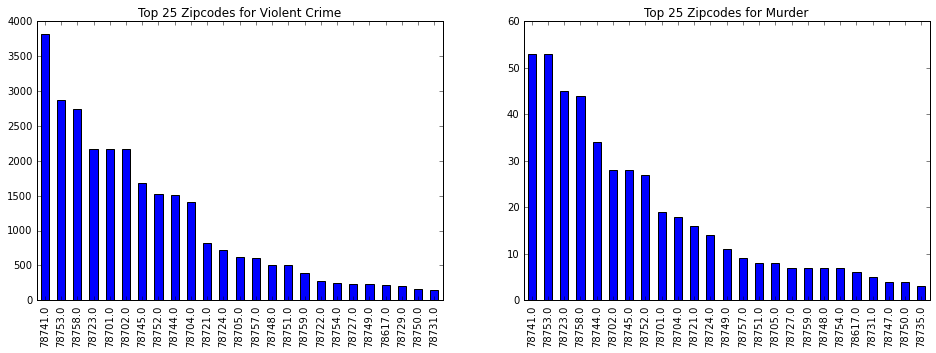

highest_offense_description,AGG ASSAULT,AGG ROBBERY/DEADLY WEAPON,CAPITAL MURDER,MURDER,RAPE
zip_code,,,,,
78610.0,1,0,0,0,0
78613.0,15,11,0,1,6
78617.0,121,62,0,6,37
78621.0,1,0,0,0,0
78634.0,1,0,0,0,0
78652.0,2,0,0,0,0
78653.0,10,3,0,1,1
78660.0,65,28,0,2,17
78664.0,3,0,0,0,0


<Figure size 432x288 with 0 Axes>

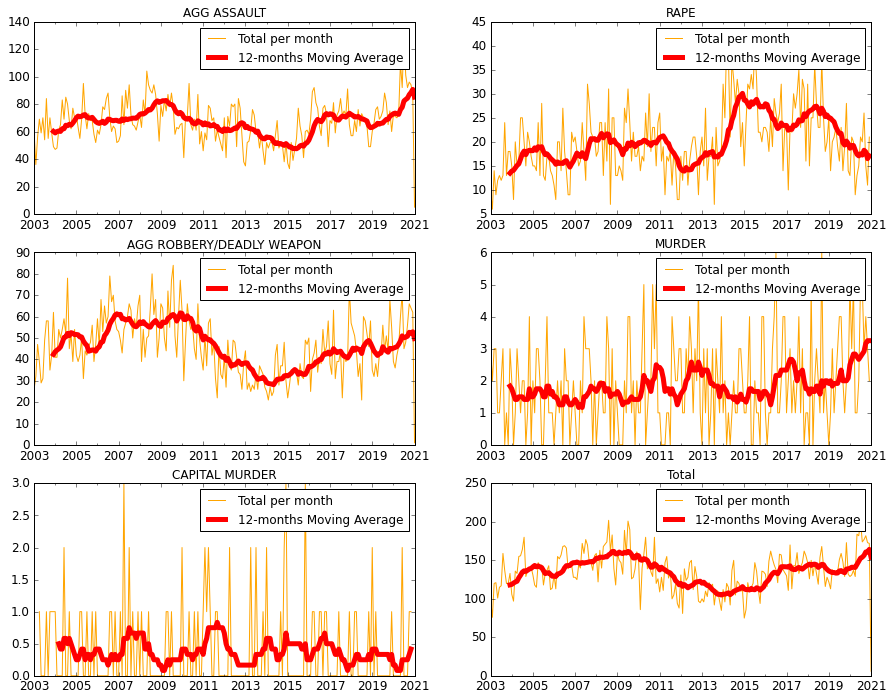

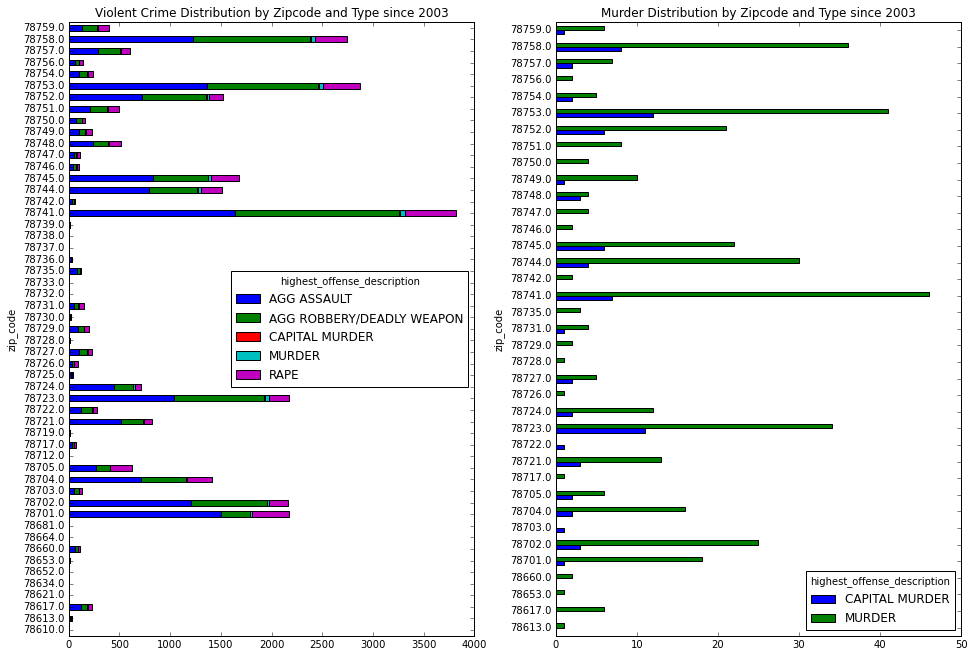

In [24]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=2)
df_viol.zip_code.value_counts().head(25).plot.bar(
    title="Top 25 Zipcodes for Violent Crime", ax=axs[0]
)
df_viol_mur.zip_code.value_counts().head(25).plot.bar(
    title="Top 25 Zipcodes for Murder", ax=axs[1]
)
plt.show()

viol_freq = pd.crosstab(df_viol.zip_code, df_viol.highest_offense_description)
mur_freq = pd.crosstab(df_viol_mur.zip_code, df_viol_mur.highest_offense_description)
display(viol_freq)

monthly = pd.DataFrame(
    df_viol[df_viol["highest_offense_description"] == "AGG ASSAULT"]
    .resample("M")
    .size()
)
monthly.columns = ["AGG ASSAULT"]

for i in df_viol["highest_offense_description"].unique():
    monthly[i] = pd.DataFrame(
        df_viol[df_viol["highest_offense_description"] == i].resample("M").size()
    )

monthly["Total"] = monthly.sum(axis=1)

crimeTypes = monthly.columns

plt.figure(1)
plt.figure(figsize=(15, 20))

i = 521
for eachCrime in crimeTypes:
    plt.subplot(i)
    monthly[eachCrime].plot(color="orange", label="Total per month")
    monthly[eachCrime].rolling(window=12).mean().plot(
        color="red", linewidth=5, label="12-months Moving Average"
    )
    plt.title(eachCrime, fontsize=12)
    plt.xlabel("")
    plt.legend(prop={"size": 12})
    plt.tick_params(labelsize=12)
    i = i + 1

fig, axs = plt.subplots(figsize=(16, 11), ncols=2)
viol_freq.plot.barh(
    title="Violent Crime Distribution by Zipcode and Type since 2003",
    ax=axs[0],
    stacked=True,
)
mur_freq.plot.barh(
    title="Murder Distribution by Zipcode and Type since 2003", ax=axs[1]
)
plt.show()

#### Distribution of violent crime and murders across council districts, APD Districts, and APD sectors 

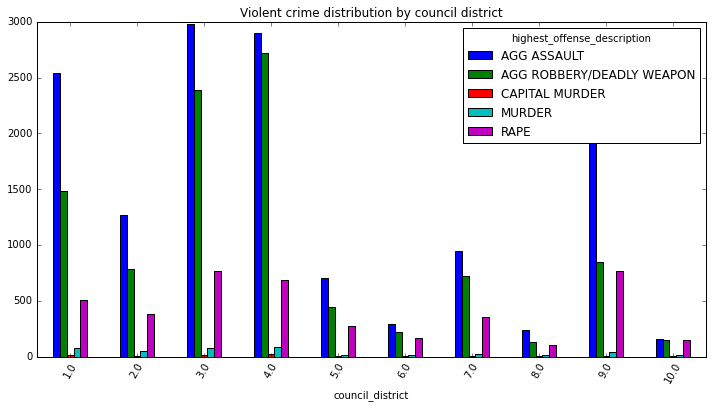

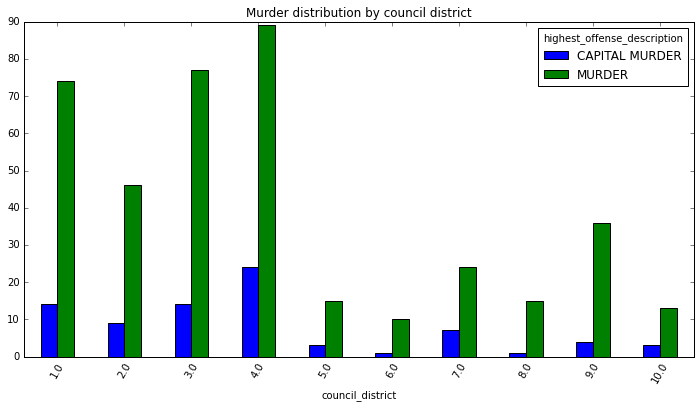

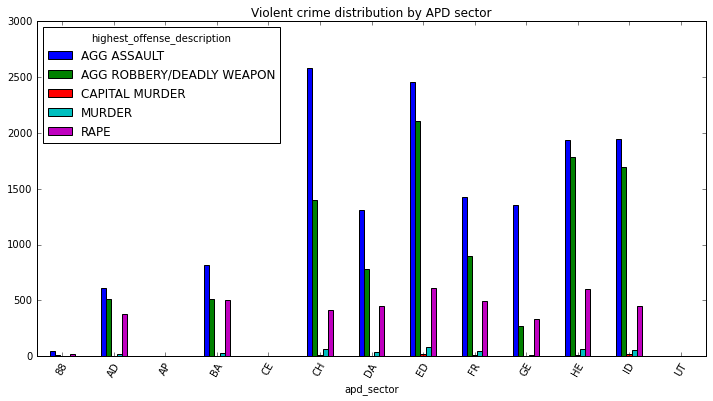

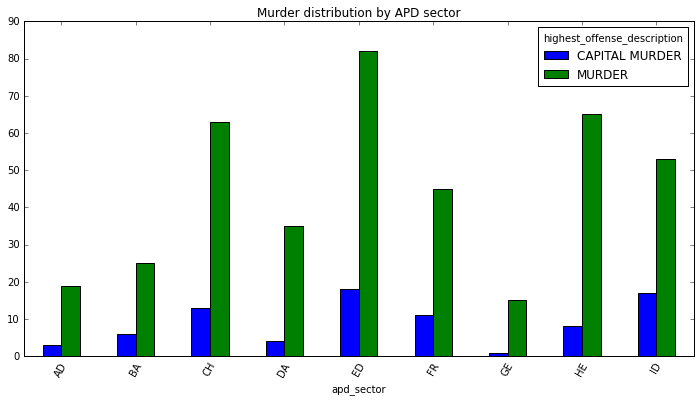

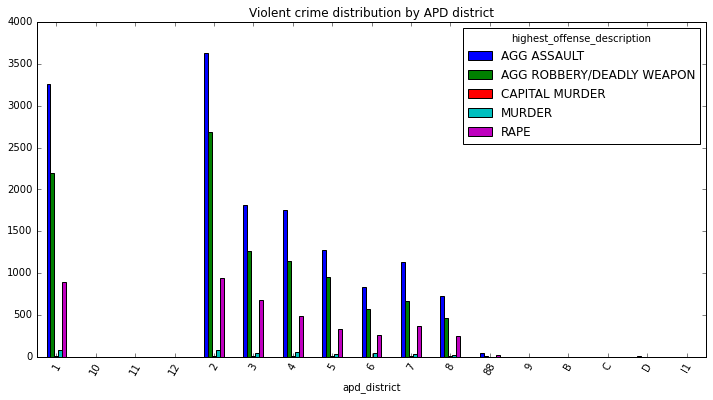

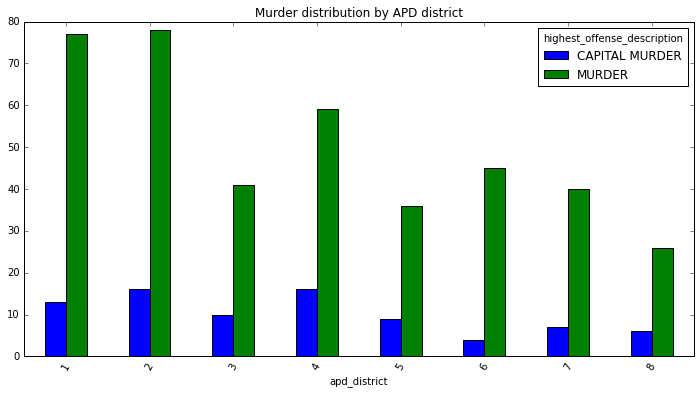

In [14]:
pd.crosstab(df_viol.council_district, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Violent crime distribution by council district"
)
plt.show()

pd.crosstab(
    df_viol_mur.council_district, df_viol_mur.highest_offense_description
).plot.bar(figsize=(12, 6), rot=60, title="Murder distribution by council district")
plt.show()

pd.crosstab(df_viol.apd_sector, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Violent crime distribution by APD sector"
)
plt.show()

pd.crosstab(df_viol_mur.apd_sector, df_viol_mur.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Murder distribution by APD sector"
)
plt.show()

pd.crosstab(df_viol.apd_district, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Violent crime distribution by APD district"
)
plt.show()

pd.crosstab(df_viol_mur.apd_district, df_viol_mur.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Murder distribution by APD district"
)
plt.show()

#### Violent crime and murder distribution by location type

highest_offense_description,AGG ASSAULT,AGG ROBBERY/DEADLY WEAPON,CAPITAL MURDER,MURDER,RAPE
location_type,,,,,
ABANDONED/CONDEMNED STRUCTURE,13,7,0,1,4
AMUSEMENT PARK,0,1,0,1,0
ARENA / STADIUM / FAIRGROUNDS / COLISEUM,2,0,0,0,0
ATM SEPARATE FROM BANK,1,2,0,0,0
AUTO DEALERSHIP NEW / USED,10,2,0,0,1
BANKS / SAVINGS & LOAN,5,134,0,1,1
BAR / NIGHT CLUB,653,45,2,7,77
CAMP / CAMPGROUND,20,2,0,0,2
CHURCH / SYNAGOGUE / TEMPLE / MOSQUE,20,5,1,0,7


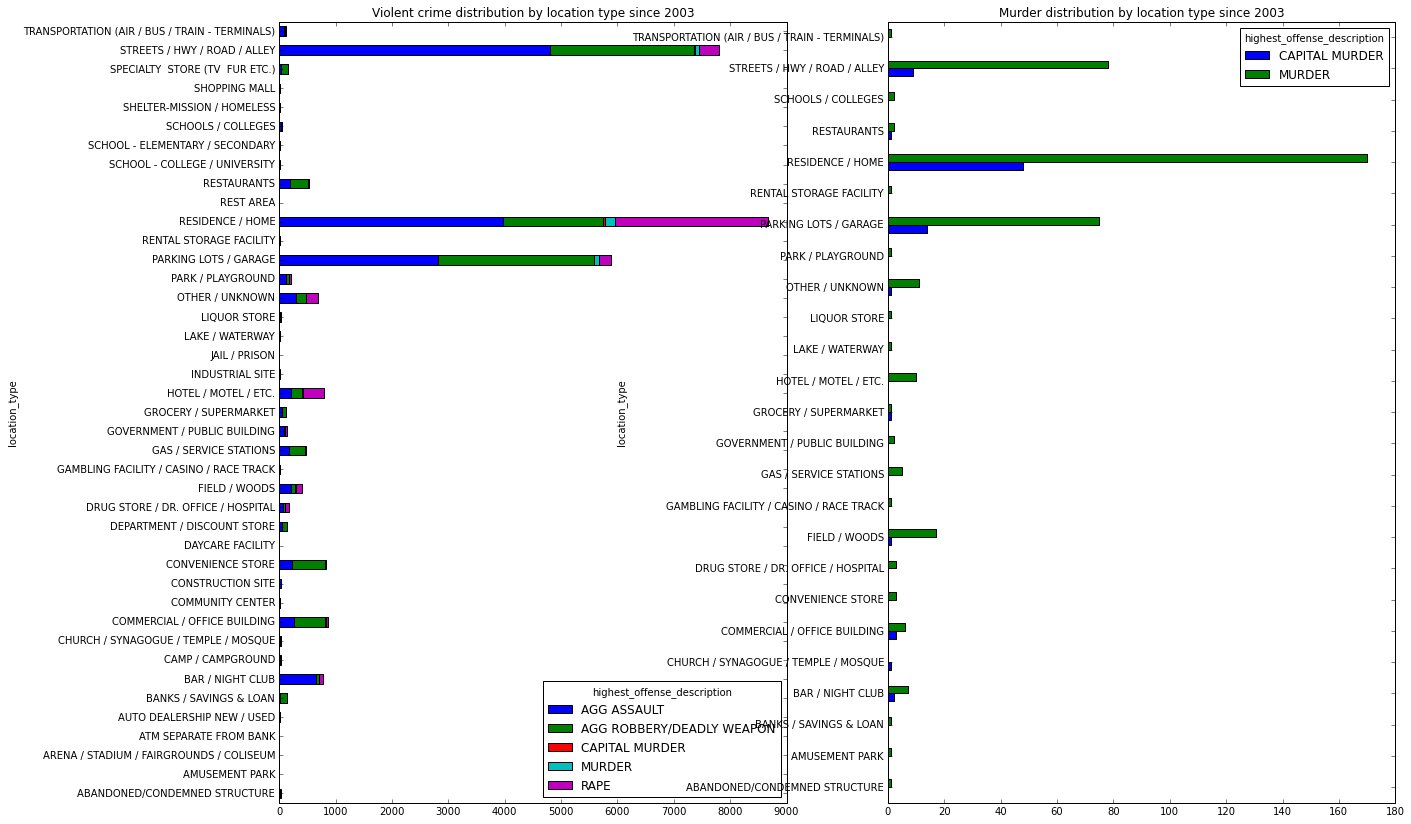

In [15]:
viol_loc = pd.crosstab(df_viol.location_type, df_viol.highest_offense_description)
display(viol_loc)
mur_loc = pd.crosstab(
    df_viol_mur.location_type, df_viol_mur.highest_offense_description
)

fig, axs = plt.subplots(figsize=(20, 14), ncols=2)
viol_loc.plot.barh(
    title="Violent crime distribution by location type since 2003",
    ax=axs[0],
    stacked=True,
)
mur_loc.plot.barh(title="Murder distribution by location type since 2003", ax=axs[1])
plt.show()

<a id='q9'></a>
### I. Question 9. How does violent crime appear on the map?

** Note: Rape incidents provide no location coordinates therefore cannot be shown on a map. **

#### Aggravated assault 

In [16]:
agg_asslt_coords_heat = df_agg_asslt[
    (df_agg_asslt["latitude"].isnull() == False)
    & (df_agg_asslt["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(agg_asslt_coords_heat[["latitude", "longitude"]].values, radius=15)
)

k.save(outfile="agg_asslt_heatmap.html")

k

#### Armed robbery 

In [17]:
agg_robbery_coords_heat = df_agg_robbery[
    (df_agg_robbery["latitude"].isnull() == False)
    & (df_agg_robbery["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(
        agg_robbery_coords_heat[["latitude", "longitude"]].values, radius=15
    )
)

k.save(outfile="agg_robbery_heatmap.html")

k

<a id='q8'></a>
#### Murder  

In [18]:
mur_coords_heat = df_viol_mur[
    (df_viol_mur["latitude"].isnull() == False)
    & (df_viol_mur["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(mur_coords_heat[["latitude", "longitude"]].values, radius=15)
)

k.save(outfile="mur_heatmap.html")

k

<a id='q10'></a>
### J. Question 10. Are there any addresses where violent crime and murder occurs frequently?

In [19]:
# Show addresses with 50 or more reported violent crimes
df_viol.address.value_counts().head(13)

500 E 7TH ST                83
9515 N LAMAR BLVD           66
1700 BURTON DR              62
6409 SPRINGDALE RD          59
00 BLOCK UNKNOWN            59
9601 MIDDLE FISKVILLE RD    58
900 BLOCK E 32ND ST         54
1030 NORWOOD PARK BLVD      53
9200 NORTH PLZ              53
1071 CLAYTON LN             53
1137 GUNTER ST              51
2237 E RIVERSIDE DR         51
1124 RUTLAND DR             50
Name: address, dtype: int64

In [20]:
# Show addresses with 2 or more reported murders
df_viol_mur.address.value_counts().head(31)

8800 N IH 35 SVRD SB         3
6407 SPRINGDALE RD           3
6409 SPRINGDALE RD           3
8610 N LAMAR BLVD            3
4700 E RIVERSIDE DR          3
8225 SAM RAYBURN DR          2
7000 DECKER LN               2
9601 MIDDLE FISKVILLE RD     2
9200 NORTH PLZ               2
2508 E RIVERSIDE DR          2
744 W WILLIAM CANNON DR      2
1050 SPRINGDALE RD           2
601 E 15TH ST                2
1711 RUTLAND DR              2
2915 S IH 35 SVRD NB         2
6118 FAIRWAY ST              2
605 MASTERSON PASS           2
2101 ELMONT DR               2
2501 ANKEN DR                2
1137 GUNTER ST               2
815 W SLAUGHTER LN           2
9220 N IH 35 SVRD SB         2
2400 WICKERSHAM LN           2
10610 MORADO CIR             2
9010 GALEWOOD DR             2
6600 ED BLUESTEIN BLVD SB    2
8912 N LAMAR BLVD            2
2713 S CONGRESS AVE          2
833 FAIRFIELD DR             2
10503 N LAMAR BLVD           2
201 W 5TH ST                 2
Name: address, dtype: int64

In [21]:
df_clean = df.copy()
df_clean.to_csv("df_clean.csv")

df_17.to_csv("df_17.csv")
df_18.to_csv("df_18.csv")
df_19.to_csv("df_19.csv")
df_20.to_csv("df_20.csv")

df_viol_17.to_csv("df_viol_17.csv")
df_viol_18.to_csv("df_viol_18.csv")
df_viol_19.to_csv("df_viol_19.csv")
df_viol_20.to_csv("df_viol_20.csv")

df_viol_mur_17.to_csv("df_viol_mur_17.csv")
df_viol_mur_18.to_csv("df_viol_mur_18.csv")
df_viol_mur_19.to_csv("df_viol_mur_19.csv")
df_viol_mur_20.to_csv("df_viol_mur_20.csv")

df_viol.to_csv("df_viol.csv")
df_viol_mur.to_csv("df_viol_mur.csv")

df_01.to_csv("df_01.csv")
df_53.to_csv("df_53.csv")
df_41.to_csv("df_41.csv")
df_45.to_csv("df_45.csv")
df_05.to_csv("df_05.csv")